In [1]:
import pandas as pd
from xgboost import XGBRegressor, XGBClassifier
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn import linear_model
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

/Users/batuan/.local/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
author_data = pd.read_csv("./authorData.csv")
test_pd = pd.read_csv('./test.csv')
train_pd = pd.read_csv('./train.csv')

In [ ]:
author_mean_count = author_data[['engagement', 'author',  'followers']].groupby(['author']).agg(size=('engagement', 'size'), mean_e=('engagement', 'mean'), std_e=('engagement', np.std), max_e=('engagement', np.max), min_e=('engagement', np.min), mean_f=('followers', 'mean'),).reset_index().fillna(0)
pd.merge(train_pd, author_mean_count, how='left', on=['author'])

In [4]:
#author_mean_count = author_data[['engagement', 'author',  'followers']].groupby(['author']).agg(size=('engagement', 'size'),mean_e=('engagement', 'mean'), mean_f=('followers', 'mean'), std_e=('engagement', np.std), ).reset_index().fillna(0)
author_mean_count = author_data[['engagement', 'author',  'followers']].groupby(['author']).agg(size=('engagement', 'size'), mean_e=('engagement', 'mean'), std_e=('engagement', np.std), max_e=('engagement', np.max), min_e=('engagement', np.min), mean_f=('followers', 'mean'),).reset_index().fillna(0)
def pre_processing_data(df):
    # df['is_reply'] = df['is_reply'].map(lambda x: 1 if x else 0)
    # df['is_retweet'] = df['is_retweet'].map(lambda x: 1 if x else 0)
    # df['contains_video'] = df['contains_video'].map(lambda x: 1 if x else 0)
    # df['contains_image'] = df['contains_image'].map(lambda x: 1 if x else 0)
    df['shared_url_domain'] = df['shared_url_domain'].map(lambda x: 0 if pd.isna(x) else 1)
    df['month'] = pd.to_datetime(df['timestamp'], unit='ms').dt.day
    df['hour'] = pd.to_datetime(df['timestamp'], unit='ms').dt.hour
    # df['feature1'] = df['feature1'].astype('str')
    # df['feature2'] = df['feature2'].astype('str')
    merge = pd.merge(df, author_mean_count, how='left', on=['author'])
    diff_train_id = list(set(df.author.unique()) - set(author_data.author.unique()))
    for x in diff_train_id:
        merge.loc[merge.author==x, 'mean_e'] = merge[merge.author==x]['followers'].values/350.0
        merge.loc[merge.author==x, 'max_e'] = merge[merge.author==x]['followers'].values/350.0
        merge.loc[merge.author==x, 'min_e'] = merge[merge.author==x]['followers'].values/350.0
        merge.loc[merge.author==x, 'std_e'] = 0
        merge.loc[merge.author==x, 'mean_f'] = merge[merge.author==x]['followers'].values
    return merge
author_data = pre_processing_data(author_data)
train_pd = pre_processing_data(train_pd)
test_pd = pre_processing_data(test_pd)

In [5]:
vector_train = list(train_pd.columns)[14:1038]
train_pd_copy = train_pd.copy()
train_pd = train_pd.drop(columns=vector_train)
# train_pd = train_pd.drop(columns=['timestamp', 'followers'])

In [8]:
train_pd[train_pd.author=='8f21524a26f1102cf6bae5ebad288168'].drop(columns=['timestamp',	'language',	'feature1',	'feature2'])

,engagement,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
2858,970456,14189,8f21524a26f1102cf6bae5ebad288168,9,0,0,False,False,True,False,19,18,27.0,813.814815,780.083824,2497.0,27.0,13461.037037


In [261]:
train_process = train_pd.drop(columns=['timestamp', 'language', 'followers', 'author', 'shared_url_domain', 'size'])
col = ['engagement', 'feature1', 'feature2', 'word_count', 'shared_url_count','month',
       'hour', 'mean_e', 'std_e', 'max_e', 'min_e', 'mean_f',
       'is_reply', 'is_retweet', 'contains_video', 'contains_image']

train_process['is_reply'] = train_process['is_reply'].map({True: 'TRUE', False: 'FALSE'})
train_process['contains_video'] = train_process['contains_video'].map({True: 'TRUE', False: 'FALSE'})
train_process['is_retweet'] = train_process['is_retweet'].map({True: 'TRUE', False: 'FALSE'})
train_process['contains_image'] = train_process['contains_image'].map({True: 'TRUE', False: 'FALSE'})

train_process[col].to_csv('train_process.csv', index=False)

In [ ]:
col_test = ['Id','feature1', 'feature2', 'word_count', 'shared_url_count',
       'is_reply', 'contains_video', 'contains_image', 'month',
       'hour', 'mean_e', 'std_e', 'max_e', 'min_e', 'mean_f']
test_pd_process = test_pd[col_test]

test_pd_process['is_reply'] = test_pd_process['is_reply'].map({True: 'TRUE', False: 'FALSE'})
test_pd_process['contains_video'] = test_pd_process['contains_video'].map({True: 'TRUE', False: 'FALSE'})
test_pd_process['contains_image'] = test_pd_process['contains_image'].map({True: 'TRUE', False: 'FALSE'})

test_pd_process.to_csv('test_pd_process.csv', index=False)

In [ ]:
#create a correlation matrix from each numeric data
# features = ['category_id','views','likes','dislikes','comment_count','No_tags','desc_len','len_title']
corr_= train_pd.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu");

# Anomaly detection in dataset

In [ ]:
author_data[['engagement', 'author', 'followers']].groupby(['author']).aggregate('mean')

In [ ]:
author_data[author_data['engagement']>100000].sort_values('engagement')

In [ ]:
author_data[author_data.author=='a8653efd261801710ce68e751802664d'].sort_values('engagement')

In [ ]:
train_pd

In [ ]:
train_pd[train_pd['engagement']>100000]

In [288]:
(author_mean_count['mean_f']/(author_mean_count['mean_e']+1)).mean()

346.90426755247404

In [ ]:
author_mean_count.iloc[518]

In [ ]:
author_mean_count = author_data[['engagement', 'author',  'followers']].groupby(['author']).agg(size=('engagement', 'size'),mean_e=('engagement', 'mean'), mean_f=('followers', 'mean'), std_e=('engagement', np.std), ).reset_index().fillna(0)
author_mean_count['mean_f']/author_mean_count['mean_e']

In [ ]:
author_mean_count[author_mean_count.author==author_id]

In [199]:
np.max(author_data[author_data.author=='b56c0e167ba6d12f540cc9874292c3cf']['engagement'].values)

185210

In [ ]:
author_data[['author',  'followers']].groupby(['author']).aggregate('std')

In [ ]:
list(set(train_pd.author.unique())-set(author_data.author.unique()))

In [230]:
merge = pd.merge(train_pd, author_mean_count, how='left', on=['author'])
merge[merge['author']=='6cc59b7b96a881dc2ef556d86983bc60']
# merge

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1022,V1023,V1024,day_of_week,hour,index,count,mean_e,mean_f,std_e
1341,16,1655770940254,en,100,5,70,6cc59b7b96a881dc2ef556d86983bc60,28,1,http://ludus.com/,...,0.016508,0.016903,0.011052,1,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
author_id = 'b56c0e167ba6d12f540cc9874292c3cf'
#'4ef9ab6a2efc6ee86201f2f7be35f335'
#'06c833d1e20532259582410172884bdd'
#''d232857c1754d01abbf53c3c4b0f2d94'

train_pd[train_pd.author==author_id]

In [ ]:
test_pd[test_pd.author=='cb2ce958fb272bc7ae93e3ef91772708']

In [ ]:
train_pd[train_pd.author=='cb2ce958fb272bc7ae93e3ef91772708']

In [11]:
np.abs(elsatic_pipeline.predict(X_test)-y_test).sort_values().tail(300).items()

In [ ]:
for i, v in np.abs(elsatic_pipeline.predict(X_test)-y_test).sort_values().tail(300).items():
    author_id = X_test[X_test.index==i]['author'].values[0]
    nb_author = len(author_data[author_data.author==author_id])
    nb_train = len(train_pd[train_pd.author==author_id])
    if (nb_author > 20) & (nb_train>5):
        print(author_id)

In [28]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
drop_c = list(train_pd.columns[14:1038]) + ['author', 'engagement', 'size', 'timestamp']
transform = linear_preprocessor.fit_transform(author_data.sample(200000, random_state=42)[train_pd.drop(drop_c, axis=1).columns]).toarray()

from pyod.models.pca import PCA
from pyod.models.knn import KNN
from sklearn.neighbors import LocalOutlierFactor

contamination = 0.15
clf = LocalOutlierFactor(n_neighbors=3, metric='minkowski', n_jobs=-1, novelty=True)

#KNN()
# clf = KNN(contamination=contamination, n_neighbors=3, metric='manhattan', n_jobs=-1)
#PCA(n_components=3, contamination=contamination)
#AutoEncoder(epochs=30, contamination=contamination)
# prediction = clf.fit_predict(transform)
clf.fit(transform)

In [ ]:
author_data[author_data['engagement']>200000].sort_values('engagement')

In [ ]:
train_pd[train_pd['engagement']>60000].sort_values('engagement')

In [21]:
a = clf.predict(linear_preprocessor.transform(train_pd.drop(drop_c, axis=1)).toarray())
train_pd[a==-1].sort_values('engagement')

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1021,V1022,V1023,V1024,month,hour,size,mean_e,mean_f,std_e


In [ ]:
author_data[author_data.author=='a788526664c805d34227370b7ae36fef']

In [46]:
bool_var = (train_pd['engagement']>train_pd['max_e']*1.5) & (train_pd['engagement']>50000)
train_h = train_pd[bool_var]
train_l = train_pd[~bool_var]
# train_h[train_h['max_e']>100].sort_values('engagement')

In [220]:
author_data[author_data.author=='829ca803f786ab21cc3d9edeb7edd70f']

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,contains_video,contains_image,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
1685,3058,1654990246254,en,32,0,11687909,829ca803f786ab21cc3d9edeb7edd70f,11,2,1,...,0,1,11,23,95,4458.284211,3540.8115,21782,1578,1.168645e+07
6811,3410,1655783139254,en,0,0,11692515,829ca803f786ab21cc3d9edeb7edd70f,10,2,1,...,1,0,21,3,95,4458.284211,3540.8115,21782,1578,1.168645e+07
12125,3910,1654674948254,en,59,0,11687167,829ca803f786ab21cc3d9edeb7edd70f,10,2,1,...,0,1,8,7,95,4458.284211,3540.8115,21782,1578,1.168645e+07
26241,6163,1655610485254,en,0,0,11690288,829ca803f786ab21cc3d9edeb7edd70f,5,2,1,...,0,1,19,3,95,4458.284211,3540.8115,21782,1578,1.168645e+07
27580,8953,1654466152254,en,28,0,11686582,829ca803f786ab21cc3d9edeb7edd70f,12,2,1,...,0,1,5,21,95,4458.284211,3540.8115,21782,1578,1.168645e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601440,2931,1655082584254,en,0,5,11687522,829ca803f786ab21cc3d9edeb7edd70f,6,2,1,...,0,1,13,1,95,4458.284211,3540.8115,21782,1578,1.168645e+07
602913,3195,1654123037254,en,42,0,11688433,829ca803f786ab21cc3d9edeb7edd70f,10,2,1,...,0,0,1,22,95,4458.284211,3540.8115,21782,1578,1.168645e+07
612863,2746,1655788249254,en,12,0,11691418,829ca803f786ab21cc3d9edeb7edd70f,9,2,1,...,0,1,21,5,95,4458.284211,3540.8115,21782,1578,1.168645e+07
612888,11251,1653459901254,en,57,-5,11680019,829ca803f786ab21cc3d9edeb7edd70f,14,2,1,...,0,1,25,6,95,4458.284211,3540.8115,21782,1578,1.168645e+07


In [219]:
test_pd[test_pd.author=='829ca803f786ab21cc3d9edeb7edd70f']

,Id,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1024,month,hour,size,mean_e,std_e,max_e,min_e,mean_f,engagement
919,1218,1655788856254,en,72,0,11691675,829ca803f786ab21cc3d9edeb7edd70f,15,0,0,...,0.037742,21,5,95.0,4458.284211,3540.8115,21782.0,1578.0,1.168645e+07,4251.914949
1102,1474,1655789423254,en,0,0,11692149,829ca803f786ab21cc3d9edeb7edd70f,7,2,1,...,0.044796,21,5,95.0,4458.284211,3540.8115,21782.0,1578.0,1.168645e+07,5518.022252
1338,1785,1655788086254,en,19,0,11692441,829ca803f786ab21cc3d9edeb7edd70f,9,0,0,...,0.045150,21,5,95.0,4458.284211,3540.8115,21782.0,1578.0,1.168645e+07,5390.223371


In [ ]:
test_pd.sort_values('followers').tail(30)

In [ ]:
train_h.sort_values('engagement', ascending=False)

In [271]:
#fdd641c3aa46d31d172e0c7d483be63a
from sklearn.compose import make_column_selector
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
print(cat_selector(author_data))
print(num_selector(author_data))

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
elsatic_pipeline = make_pipeline(linear_preprocessor, ElasticNet())
bagging_pipeline = make_pipeline(tree_preprocessor, BaggingRegressor())
SVR_pipeline = make_pipeline(num_linear_processor, SVR(kernel='poly'))
KNN_pipeline = make_pipeline(tree_preprocessor, KNeighborsRegressor())


rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
gbdt_pipeline = make_pipeline(
    tree_preprocessor, GradientBoostingRegressor(random_state=0)
)
# estimators = [
#     ("Random Forest", rf_pipeline),
#     ("Lasso", lasso_pipeline),
#     ("Gradient Boosting", gbdt_pipeline),
# ]

estimators = [
    ("Random Forest", KNN_pipeline),
    ("Lasso", rf_pipeline),
    ("Gradient Boosting", SVR_pipeline),
    ("bag", bagging_pipeline)
]

estimators_tree_base = [
    ("Random Forest", rf_pipeline),
    ("xgboost", make_pipeline(tree_preprocessor, XGBRegressor())),
    ("Decision Tree", make_pipeline(tree_preprocessor, DecisionTreeRegressor())),
    ("Adaboost", make_pipeline(tree_preprocessor, AdaBoostRegressor()))
]

stacking_regressor_tree = StackingRegressor(estimators=estimators_tree_base, final_estimator=GradientBoostingRegressor())
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(), )

# X_sample = author_data.copy()
# y = X_sample.engagement
# X = X_sample[author_data.columns].drop(['engagement'], axis=1)
# X['shared_url_domain'] = X['shared_url_domain'].map(lambda x: 'null' if pd.isna(x) else x)

train_pd_copy = train_pd.copy()#[train_pd.engagement<400000]
X_train_data = train_pd_copy.drop(['engagement', 'size', 'timestamp', 'shared_url_domain', 'followers', 'language', 'author', 'is_retweet'], axis=1)
# X_train_data = X_train_data.drop(columns=vector_train)
# X_train_data['shared_url_domain'] = X_train_data['shared_url_domain'].map(lambda x: 'null' if pd.isna(x) else x)

y_train_data = train_pd_copy.engagement

X_train, X_test, y_train, y_test = train_test_split(
    X_train_data, y_train_data, test_size=0.33, random_state=42)

['language', 'author']
['engagement', 'timestamp', 'feature1', 'feature2', 'followers', 'word_count', 'shared_url_count', 'shared_url_domain', 'month', 'hour', 'size', 'mean_e', 'std_e', 'max_e', 'min_e', 'mean_f']


In [ ]:
linear_preprocessor.fit(X_train_data)
X_train_transform = linear_preprocessor.transform(X_train_data)
xgb_gridsearch = GridSearchCV(XGBRegressor(), {
                'learning_rate': [0.001],
                  'n_estimators' : [100,200,500],
                  'max_depth'    : [4,6,10, 14]
                 }, cv=10, scoring='neg_mean_absolute_error', 
                             refit=True, n_jobs=8, verbose=3)
xgb_gridsearch.fit(X_train_transform, y_train_data)
print(xgb_gridsearch.best_estimator_)

In [ ]:
xgb_gridsearch.predict(linear_preprocessor.transform(X_test_dat))

In [182]:
test_pd[test_pd.author=='8f21524a26f1102cf6bae5ebad288168']

,Id,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1024,month,hour,size,mean_e,std_e,max_e,min_e,mean_f,engagement


In [62]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
scores = cross_val_score(stacking_regressor, X_train_data, y_train_data, cv = 5, scoring='neg_root_mean_squared_error')
scores

array([-57929.28301543, -46228.51083182, -67117.81081031, -60678.09439459,
       -60851.74506206])

In [43]:
y_pred = cross_val_predict(stacking_regressor, X_train_data, y_train_data, n_jobs=-1, verbose=0)

In [192]:
linear_preprocessor.fit(X_train_data)
X_train_transform = linear_preprocessor.transform(X_train_data)

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_gridsearch = GridSearchCV(XGBRegressor(), {
                'learning_rate': [0.001, 0.01, 0.02],
                  'n_estimators' : [100,200,500],
                  'max_depth'    : [4,6,10, 12, 14]
                 }, cv=10, scoring='neg_mean_absolute_error', 
                             refit=True, n_jobs=8, verbose=3)
xgb_gridsearch.fit(X_train_data, y_train_data)
print(xgb_gridsearch.best_estimator_)

In [288]:
X_test_submit = test_pd[X_train_data.columns]
y_test_submit = xgb_gridsearch.best_estimator_.predict(X_test_submit)#linear_preprocessor.transform(X_test_submit))

In [290]:
y_test_submit.min()

287.9993

In [ ]:
stack_tree = StackingRegressor(
    estimators=[
        ('decisiontree', DecisionTreeRegressor(max_depth=8, min_samples_leaf=8)),
        ('xgb', XGBRegressor(learning_rate=0.001, max_depth= 6, n_estimators=500)),
        ('rf', RandomForestRegressor(max_depth=64, min_samples_leaf=16)),
        ('cb', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                       min_samples_leaf=5),
                  learning_rate=0.01)),
        ('knn', KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance'))
    ],
    cv=5,
    final_estimator=LinearRegression()
    )
from sklearn.model_selection import cross_val_score
# scores = cross_val_score(stack_tree, X_train_transform, y_train_data, cv=5, scoring='neg_root_mean_squared_error')
# scores
stack_tree.fit(X_train_transform, y_train_data)

In [163]:
stack_tree.fit(X_train_transform, y_train_data)

StackingRegressor(cv=5,
                  estimators=[('decisiontree',
                               DecisionTreeRegressor(max_depth=8,
                                                     min_samples_leaf=8)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, gr...
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=64,
                                                     min_samples_leaf=16)),
                              ('cb',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                                                      min_samples_leaf=5),
                                                 learning_rate=0.01)),
                              ('knn',
                               KNeighborsRegressor(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))],
                  final_estimator=RidgeCV())

In [203]:
rf = RandomForestRegressor(max_depth=64, min_samples_leaf=16).fit(X_train_transform, y_train_data)

In [204]:
rf.feature_importances_

array([5.76664745e-06, 0.00000000e+00, 2.41504167e-04, ...,
       2.23095883e-03, 2.80110672e-03, 7.95816445e-04])

In [194]:
X_test_submit = test_pd[X_train_data.columns]
a = stack_tree.predict(linear_preprocessor.transform(X_test_submit))
test_pd['engagement'] = a
test_pd[['Id', 'engagement']].to_csv("test_2.csv",index=False, quoting=2)

In [ ]:
author_data[author_data.author=='473d93c75fd35709b076b95c71793e47'].sort_values('engagement')

In [ ]:
train_pd_copy.sort_values('engagement')

In [61]:
X_test[1042:1043]

,feature1,feature2,word_count,shared_url_count,is_reply,contains_video,contains_image,month,hour,mean_e,std_e,max_e,min_e,mean_f
149,100,5,16,0,0,1,0,18,1,245260.25,135512.848049,412991.0,90303.0,23790.5


In [69]:
diff = np.abs(stack_tree.predict(X_test) - y_test)
test = X_test.copy()
test['e'] = y_test
test['pre'] = stack_tree.predict(X_test)
test['diff'] = diff

In [ ]:
author_id = '7809df7d75f32bfeb60e4421ea2203a0'
test_author = author_data[author_data.author==author_id]
drop_co = ['engagement', 'size', 'timestamp', 'shared_url_domain', 'followers', 'language', 'author', 
            'mean_e', 'std_e', 'max_e', 'min_e', 'mean_f']
select_co = ['feature1', 'feature2', 'word_count',]
X_test_author_data = test_author[select_co]#.drop(drop_co, axis=1)
y_test_author_data = test_author['engagement']
X_test_author_data_trans = linear_preprocessor.fit_transform(X_test_author_data)

rf = linear_model.LassoCV().fit(X_test_author_data_trans, y_test_author_data)
rf.predict(linear_preprocessor.transform(train_pd[train_pd.author==author_id][X_test_author_data.columns]))

In [ ]:
author_data[author_data.author=='7809df7d75f32bfeb60e4421ea2203a0'].sort_values('engagement')

In [154]:
train_pd[train_pd.author=='7809df7d75f32bfeb60e4421ea2203a0']

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,contains_video,contains_image,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
3466,50679,1655771135254,en,100,0,7692,7809df7d75f32bfeb60e4421ea2203a0,25,0,0,...,0,0,21,0,19.0,166574.631579,159001.013878,502696.0,80.0,7541.894737


In [153]:
train_pd[train_pd.index==3466]

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,contains_video,contains_image,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
3466,50679,1655771135254,en,100,0,7692,7809df7d75f32bfeb60e4421ea2203a0,25,0,0,...,0,0,21,0,19.0,166574.631579,159001.013878,502696.0,80.0,7541.894737


In [130]:
test.sort_values('diff').tail(10)

,feature1,feature2,word_count,shared_url_count,is_reply,contains_video,contains_image,month,hour,mean_e,std_e,max_e,min_e,mean_f,e,pre,diff
2479,44,-5,12,0,1,1,0,21,0,41905.250000,106692.115634,599607.0,62.0,1.817354e+04,5236,147584.502173,142348.502173
2662,100,-5,14,0,0,0,0,17,7,15564.223404,36817.148099,205277.0,264.0,3.714383e+03,34835,183830.172374,148995.172374
1732,100,0,14,0,0,0,0,19,22,36243.208333,81446.327921,425826.0,0.0,2.055928e+05,287081,136957.161884,150123.838116
3466,100,0,25,0,0,0,0,21,0,166574.631579,159001.013878,502696.0,80.0,7.541895e+03,50679,213890.715998,163211.715998
2062,100,5,12,0,0,0,0,20,3,61320.461538,102037.701465,307104.0,1013.0,1.462038e+04,8464,174833.188586,166369.188586
3712,100,-5,23,0,0,0,0,20,9,67072.183673,60560.087567,276099.0,9129.0,5.369726e+06,276495,60952.554266,215542.445734
3849,100,0,14,0,0,0,0,20,5,59788.333333,112966.249485,411919.0,0.0,4.826667e+03,425565,194815.672343,230749.327657
1126,100,0,13,0,0,1,0,19,5,30796.103448,52325.141372,287566.0,53.0,5.172943e+05,333362,72593.555275,260768.444725
149,100,5,16,0,0,1,0,18,1,245260.250000,135512.848049,412991.0,90303.0,2.379050e+04,534994,216909.595426,318084.404574
643,100,-5,13,0,0,0,0,21,4,105734.627660,70317.486514,554360.0,52909.0,1.709923e+06,428861,69402.054585,359458.945415


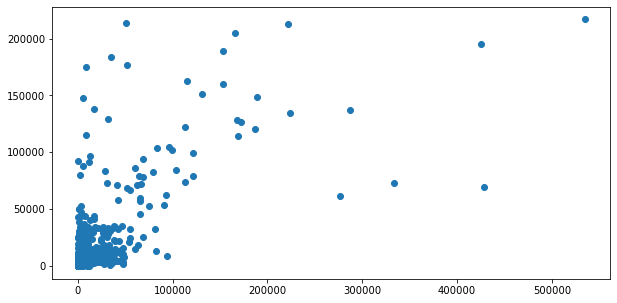

In [54]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test, stack_tree.predict(X_test))

In [57]:
stacking_regressor.fit(X_train_data, y_train_data)
X_test = test_pd[X_train_data.columns]
y_test = stacking_regressor.predict(X_test)

In [85]:
# stacking_regressor.fit(X_train, y_train)
mean_squared_error(np.abs(stacking_regressor.predict(X_test)), y_test, squared=False)

24608.417945035635

In [ ]:
a = stacking_regressor.predict(X_test)
# a[a<0] = -a[a<0]
# mean_squared_error(a, y_test, squared=False)
diff = np.abs(np.abs(a) - y_test)
diff.sort_values().tail(10)

In [162]:
stack_tree.fit(X_train, y_train)
mean_squared_error(stack_tree.predict(X_test), y_test, squared=False)

24279.431373389627

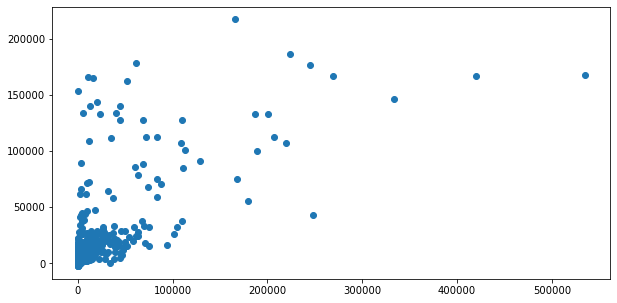

In [100]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test, stacking_regressor.predict(X_test))

In [ ]:
stacking_regressor_tree.predict(X_test).max()

In [102]:
stacking_regressor_tree.fit(X_train, y_train)
mean_squared_error(stacking_regressor_tree.predict(X_test), y_test, squared=False)

24353.55873722609

In [121]:
tree = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=200))
tree.fit(X_train, y_train)
mean_squared_error(tree.predict(X_test), y_test, squared=False)

24737.0921189657

In [630]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(train_pd_copy[vector_train].values)

In [650]:
train_pd_matrix = train_pd_copy[vector_train].values
test_pd_maxtrix = test_pd[vector_train].values
cosine_similarity(X=train_pd_matrix[0, :].reshape(1, -1), Y=train_pd_matrix)

array([[1.        , 0.68331578, 0.65175937, ..., 0.70228799, 0.75846554,
        0.50152113]])

In [659]:
sim_test = cosine_similarity(X=test_pd_maxtrix, Y=train_pd_matrix)
sim_test.argmax(axis=1)

array([1011, 2755, 3754, ..., 1503,  192,  430])

In [ ]:
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn import svm

clf = make_pipeline(linear_preprocessor, IsolationForest(contamination= 0.15, random_state=42))
a_clf = clf.fit(X_train_data).predict(X_train_data)
print(y_train_data[a_clf==-1].sort_values())

In [231]:
train_pd[a_iso==-1].sort_values('engagement').tail(10)

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1023,V1024,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
1206,441580,1655765134254,en,100,-5,8231,48be11f2e2e4df05edc18e94e53c03e3,16,0,0,...,0.004770,0.006488,20,22,11.0,69763.818182,93577.181684,245814.0,0.0,6223.363636
598,482983,1655702178254,en,59,0,12049,0c056d3c2baa5920aa732d45d64d9b45,13,0,0,...,0.022586,0.023213,20,5,6.0,62919.833333,58499.887974,138582.0,2.0,11169.666667
789,505258,1655789474254,en,40,-5,3219,dc9b3fcf1f94247f2788c49d67088a19,7,0,0,...,0.022628,0.046947,21,5,21.0,23421.190476,40955.279045,124179.0,0.0,2515.714286
149,534994,1655515820254,en,100,5,23730,473d93c75fd35709b076b95c71793e47,16,0,0,...,0.015438,0.031670,18,1,4.0,245260.250000,135512.848049,412991.0,90303.0,23790.500000
1020,569098,1655771193254,en,37,0,61050,ae45818297aac4b799bcbe18226a5118,15,0,0,...,0.009292,0.028699,21,0,28.0,28333.750000,123843.273279,655023.0,0.0,60528.035714
3178,628572,1654845050254,en,100,5,10104,8090d380f8ddabfaf224ace747c4013f,41,0,0,...,0.014675,0.032577,10,7,72.0,148.263889,190.324481,1569.0,81.0,8572.902778
3924,663649,1655685201254,en,34,0,4989,c94d2149350ff12212b93e0c5e1a5923,7,0,0,...,0.012158,0.033894,20,0,62.0,13559.500000,53615.077182,359435.0,0.0,4318.096774
2426,714198,1655681327254,en,81,5,78676,4e09ac1b2e25c6bb99acbe950e3e0bff,21,0,0,...,0.012797,0.022730,19,23,97.0,8307.690722,33180.541464,307192.0,1148.0,76572.360825
1928,772150,1655681145254,en,67,-5,7616,a8653efd261801710ce68e751802664d,10,0,0,...,0.020028,0.031278,19,23,17.0,14715.647059,22137.017603,72157.0,11.0,7417.941176
430,797002,1655750444254,en,65,5,41719,fd41db44ac4d75cd36a855efac4e39f2,20,0,0,...,0.024045,0.044270,20,18,75.0,9310.933333,27727.404839,149352.0,0.0,40741.200000


In [241]:
features_col = ['feature1', 'feature2', 'word_count', 'shared_url_count', 'is_reply', 'contains_video', 'contains_image', 'month', 'hour', 'max_e', 'mean_f']

In [244]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination= 0.05, random_state=42)
iso.fit(X_train_data[features_col])
clf = LocalOutlierFactor(n_neighbors=10)
a_clf = clf.fit_predict(X_train_data[features_col])
a_iso = iso.predict(X_train_data[features_col])
# print(y_train_data[a_clf==-1].sort_values())
print(y_train_data[a_iso==-1].sort_values())

/Users/batuan/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


725          0
823          0
408          1
223          2
2478         3
         ...  
4137    420204
3223    439173
149     534994
3178    628572
2426    714198
Name: engagement, Length: 208, dtype: int64


In [625]:
sim = (similarity + np.identity(similarity.shape[0])*-2).argmax(axis=1)
train_pd_copy['sim_max'] = sim
sim

array([3910, 3482, 3912, ..., 3634,  233, 3391])

In [544]:
from sklearn.base import BaseEstimator, TransformerMixin
class BasePipeStep(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        return X

class SelectColumns(BasePipeStep):

    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

class PopularTagFeature(BasePipeStep):
        
    def fit(self,X, y=None):
        df_gb_tags_long = []
        for index, row in X[['video_id', 'tag_list']].iterrows():
            video_id = row['video_id']
            tags = row['tag_list']
            for tag in tags:
                df_gb_tags_long.append({'video_id':video_id,'tag':tag})
        df_gb_tags_long = pd.DataFrame(df_gb_tags_long)
        self.tag_summary = (
            df_gb_tags_long
            .assign(tag=lambda x: x.tag.str.lower())
            .set_index('video_id')
            .join(X.set_index('video_id'))
            .reset_index()
            .groupby('tag')
            .agg({'video_id':'nunique', 'likes':'mean', 'views':'mean'})
            .sort_values('likes', ascending=False)
            .head(30)
            .index
            .values
        )
        return self
    
    def transform(self, X):
        X = X.copy()
        X['high_tag']  = 0

        for tag in self.tag_summary:
            X['high_tag']  += np.where(X.tags.str.contains(tag),1,0)
        return X
    
class UnpopularTagFeature(BasePipeStep):
        
    def fit(self,X, y=None):
        df_gb_tags_long = []
        for index, row in X[['video_id', 'tag_list']].iterrows():
            video_id = row['video_id']
            tags = row['tag_list']
            for tag in tags:
                df_gb_tags_long.append({'video_id':video_id,'tag':tag})
        df_gb_tags_long = pd.DataFrame(df_gb_tags_long)
        self.tag_summary = (
            df_gb_tags_long
            .assign(tag=lambda x: x.tag.str.lower())
            .set_index('video_id')
            .join(X.set_index('video_id'))
            .reset_index()
            .groupby('tag')
            .agg({'video_id':'nunique', 'likes':'mean', 'views':'mean'})
            .sort_values('likes')
            .head(30)
            .index
            .values
        )
        return self
    
    def transform(self, X):
        X = X.copy()
        X['low_tag']  = 0

        for tag in self.tag_summary:
            X['low_tag']  += np.where(X.tags.str.contains(tag),1,0)
        return X
 
class TimeFeatures(BasePipeStep):
    
    def transform(self, X):
        X = X.copy()
        return X.assign(
            publish_time = lambda x: pd.to_datetime(x.timestamp, unit='ms'),
            month = lambda x: x.publish_time.dt.month,
            hour = lambda x: x.publish_time.dt.hour, 
        )

class HotEncode(BasePipeStep):
    
    def __init__(self, columns):
        self.columns = columns
        
    def transform(self, X):
        X = X.copy()
        return pd.get_dummies(X, columns=self.columns, drop_first=True)
        


preprocessing = Pipeline([
    ('popular_tags', PopularTagFeature()),
    ('unpopular_tage', UnpopularTagFeature()),
    ('time_features', TimeFeatures()),
    ('select_columns', SelectColumns([
        'views','comment_count',
        'high_tag', 'low_tag',
        'month', 'hour',
        'comments_disabled', 'ratings_disabled',
        'video_error_or_removed'
    ])),
    ('hot_encode', HotEncode([
        'comments_disabled', 'ratings_disabled',
        'video_error_or_removed'
    ]))
])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('learning', XGBRegressor() )
])

In [163]:
preprocessing = Pipeline([
    ('time_features', TimeFeatures()),
    ('select_columns', SelectColumns([
        'feature1',
        'feature2', 'followers',
    ])),
])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('learning', XGBRegressor() )
])

In [164]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('time_features', TimeFeatures()),
                                 ('select_columns',
                                  SelectColumns(columns=['feature1', 'feature2',
                                                         'followers']))])),
                ('learning',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

Mean squared error: 72,268.076
R2 score: -0.2052563317632159


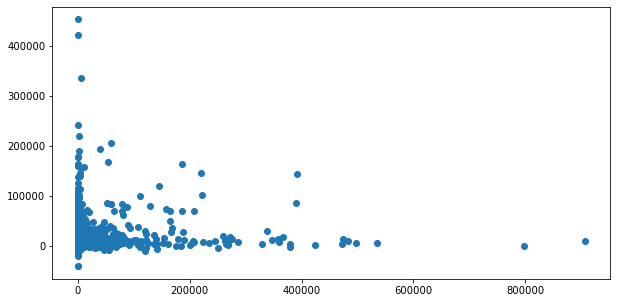

In [165]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
predictions = pipe.predict(X_test)
error = mean_squared_error(y_test, predictions, squared=False)
prediction_r2_score = r2_score(y_test, predictions)
print(f'Mean squared error: {error:,.3f}')
print(f'R2 score: {prediction_r2_score}')
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test, predictions)

In [ ]:
#42252.52755606992
#38847.93844378257
#38865.07327734479
mean_squared_error(stacking_regressor_tree.predict(X_test), y_test, squared=False)

In [ ]:
# col = ['timestamp', 'language', 'feature1', 'feature2',
#        'followers', 'author', 'word_count', 'shared_url_count',
#        'shared_url_domain', 'is_reply', 'is_retweet', 'contains_video',
#        'contains_image']
col = train_pd.columns

In [550]:
train_pd[train_pd.index==2639]
# author_data[author_data.author=='ebb3c56c7ea7ea5be18650e47208a3b8']

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image,month,hour,size,mean_e,mean_f,std_e
2639,39990,1655775522254,en,84,5,225439,ebb3c56c7ea7ea5be18650e47208a3b8,21,0,0,0,0,1,0,6,1,99.0,822.10101,222294.717172,1315.776759


Mean squared error: 6,863.147
R2 score: 0.2056965590207226


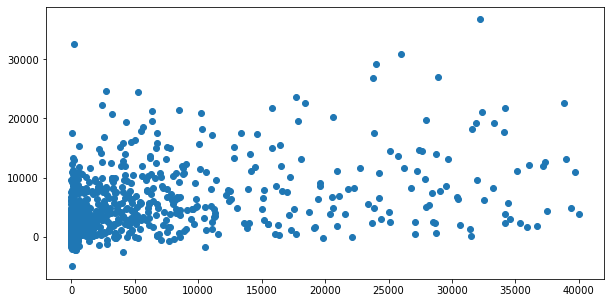

In [545]:
ada = make_pipeline(tree_preprocessor, XGBRegressor(random_state=42))
ada.fit(X_train, y_train)

predictions = ada.predict(X_test)
error = mean_squared_error(y_test, predictions, squared=False)
prediction_r2_score = r2_score(y_test, predictions)
print(f'Mean squared error: {error:,.3f}')
print(f'R2 score: {prediction_r2_score}')
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test, predictions)

In [537]:
X_test

,feature1,feature2,word_count,shared_url_count,is_reply,is_retweet,contains_video,contains_image,month,hour,mean_e,mean_f,std_e
0,100,-5,6,0,0,0,0,0,6,18,35.628866,3536.257732,150.229153
1,13,-5,7,0,0,0,1,0,6,5,820.838384,13547.636364,7347.108969
2,100,0,12,0,0,0,0,0,6,5,3822.858696,49296.913043,8440.048167
3,95,-5,22,1,0,0,0,0,6,19,762.666667,29102.606061,410.314140
4,100,0,3,0,0,0,0,0,6,5,6.419355,152.344086,33.290331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,100,5,33,0,0,0,0,1,6,13,996.688889,63658.044444,1985.652478
1867,100,-5,1,0,0,0,0,0,6,5,8.686869,504.232323,24.621480
1868,100,-5,1,0,0,0,0,0,6,5,254.200000,1347.200000,437.336484
1869,20,-5,4,0,0,0,1,0,6,3,57.989899,14841.292929,103.858370


In [716]:
author_data[author_data.author=='d232857c1754d01abbf53c3c4b0f2d94']

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image
10766,170240,1653465359254,en,100,-5,64616579,d232857c1754d01abbf53c3c4b0f2d94,48,0,NaN,False,False,False,False
22315,120586,1654153507254,en,100,-5,64750271,d232857c1754d01abbf53c3c4b0f2d94,41,0,NaN,False,False,False,False
34796,243568,1653623538254,en,100,-5,64528328,d232857c1754d01abbf53c3c4b0f2d94,31,0,NaN,False,False,False,False
43322,102626,1654628968254,en,100,-5,64732075,d232857c1754d01abbf53c3c4b0f2d94,53,0,NaN,False,False,False,False
48017,122672,1653392299254,en,58,5,64448753,d232857c1754d01abbf53c3c4b0f2d94,12,0,NaN,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586233,123550,1654620918254,en,75,5,64631697,d232857c1754d01abbf53c3c4b0f2d94,11,0,NaN,False,False,False,False
590755,109113,1654884676254,en,100,0,64729679,d232857c1754d01abbf53c3c4b0f2d94,14,0,NaN,False,False,False,False
593393,96903,1654108664254,en,100,5,64635076,d232857c1754d01abbf53c3c4b0f2d94,53,0,NaN,False,False,False,False
596631,126577,1655163971254,en,100,5,64682117,d232857c1754d01abbf53c3c4b0f2d94,47,0,NaN,False,False,False,False


In [139]:
X_test_submit[X_test_submit.isna().any(axis=1)]

,feature1,feature2,word_count,shared_url_count,is_reply,is_retweet,contains_video,contains_image,month,hour,mean_e,std_e,max_e,min_e,mean_f
202,93,0,35,0,0,0,1,0,20,5,1.620000,0.0,NaN,NaN,567.0
260,62,0,40,0,0,0,0,1,18,7,1.077143,0.0,NaN,NaN,377.0
522,100,-5,6,0,0,0,0,0,21,5,0.302857,0.0,NaN,NaN,106.0
609,79,5,48,2,0,0,1,0,21,5,0.065714,0.0,NaN,NaN,23.0
867,98,0,51,0,0,0,0,1,21,1,910.740000,0.0,NaN,NaN,318759.0
1146,50,0,8,0,0,0,1,0,17,21,1.097143,0.0,NaN,NaN,384.0
1186,50,-5,13,0,0,0,1,0,20,18,0.248571,0.0,NaN,NaN,87.0
1280,59,5,9,0,0,0,1,0,20,17,2.354286,0.0,NaN,NaN,824.0


In [ ]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination= 0.15, random_state=42)
iso.fit(X_train_data)
clf = LocalOutlierFactor(n_neighbors=3, novelty=True)
clf.fit(X_train_data)
a_clf = clf.predict(X_test_submit)
a_iso = iso.predict(X_test_submit)
test_pd[a_clf==-1]

In [148]:
author_data[author_data.author=='f9c916a4cbee1ea894bd5fa5b2f19532']

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,contains_video,contains_image,month,hour,size,mean_e,std_e,max_e,min_e,mean_f
51384,110084,1655343241254,en,100,0,1635,f9c916a4cbee1ea894bd5fa5b2f19532,14,0,0,...,0,0,16,1,9,95410.222222,69689.905703,235648,18660,1618.777778
94468,235648,1654745973254,en,100,-5,1561,f9c916a4cbee1ea894bd5fa5b2f19532,10,0,0,...,0,0,9,3,9,95410.222222,69689.905703,235648,18660,1618.777778
203588,34632,1655512288254,en,100,0,1635,f9c916a4cbee1ea894bd5fa5b2f19532,9,0,0,...,0,0,18,0,9,95410.222222,69689.905703,235648,18660,1618.777778
214505,90316,1654491386254,en,25,0,1633,f9c916a4cbee1ea894bd5fa5b2f19532,7,0,0,...,0,0,6,4,9,95410.222222,69689.905703,235648,18660,1618.777778
287492,159421,1654416077254,en,100,0,1633,f9c916a4cbee1ea894bd5fa5b2f19532,16,0,0,...,0,0,5,8,9,95410.222222,69689.905703,235648,18660,1618.777778
312061,39945,1654829486254,en,100,0,1608,f9c916a4cbee1ea894bd5fa5b2f19532,10,0,0,...,0,0,10,2,9,95410.222222,69689.905703,235648,18660,1618.777778
362573,53607,1654563973254,en,100,-5,1629,f9c916a4cbee1ea894bd5fa5b2f19532,12,0,0,...,0,0,7,1,9,95410.222222,69689.905703,235648,18660,1618.777778
427028,116379,1655168406254,en,67,0,1609,f9c916a4cbee1ea894bd5fa5b2f19532,4,0,0,...,0,0,14,1,9,95410.222222,69689.905703,235648,18660,1618.777778
569904,18660,1654664491254,en,84,-5,1626,f9c916a4cbee1ea894bd5fa5b2f19532,9,0,0,...,0,0,8,5,9,95410.222222,69689.905703,235648,18660,1618.777778


In [149]:
test_pd[a_clf==-1].sort_values('followers').tail(50)

,Id,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1024,month,hour,size,mean_e,std_e,max_e,min_e,mean_f,engagement
704,938,1655754851254,en,100,5,57427,1f4c2e13ef29a1e617938e3cae59cb29,23,0,0,...,0.012568,20,19,15.0,25999.200000,9034.040491,38446.0,0.0,5.733027e+04,14474
742,984,1655725838254,en,100,0,58498,bf3aad607dd3266aaf790412821b35c4,19,0,0,...,0.014562,20,11,99.0,418.585859,662.655111,3997.0,0.0,5.811556e+04,2785
1756,2346,1655772680254,en,43,-5,60401,e47e06d44c7511e971debe16b211afea,21,0,0,...,0.028129,21,0,55.0,372.145455,536.279896,2948.0,0.0,6.041696e+04,10011
701,935,1655781668254,en,79,0,60746,e18299e1aa37f723533f5616ebcc6e49,39,2,1,...,0.013326,21,3,99.0,200.969697,260.260994,2539.0,84.0,6.003298e+04,600
1077,1438,1655780254254,en,100,-5,61898,99b39f689d4dd25537303b7f07e33866,32,1,1,...,0.037239,21,2,99.0,630.454545,614.465045,2656.0,160.0,6.070568e+04,1966
551,733,1655754343254,en,64,-5,81542,e9f23ff57b4b731a1d3c7aaaf0cc4b8d,42,0,0,...,0.024004,20,19,100.0,13226.220000,4633.069632,36704.0,9308.0,7.858999e+04,16608
521,696,1655761346254,en,100,5,88530,6e9ddbc38532cd987ee99fa4cf1889f1,8,0,0,...,0.021947,20,21,29.0,18586.068966,14133.389379,53968.0,8.0,8.840845e+04,22960
254,333,1655774098254,en,50,0,91858,1536ba3e20b46d84c1d2eca423d3ade8,9,0,0,...,0.033197,21,1,98.0,13822.908163,11796.637875,67194.0,3989.0,8.960888e+04,4964
1569,2101,1655766176254,en,0,0,91862,1536ba3e20b46d84c1d2eca423d3ade8,5,0,0,...,0.032031,20,23,98.0,13822.908163,11796.637875,67194.0,3989.0,8.960888e+04,10556
484,647,1655785824254,en,100,-5,92969,d63b823f6709571295824e86e9af7ecd,28,0,0,...,0.027658,21,4,95.0,4702.463158,3253.022934,24839.0,1832.0,8.828197e+04,6731


## PyOD

In [723]:
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [ ]:
clf_name = 'SUOD'

# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=1), LOF(n_neighbors=2),
                    LOF(n_neighbors=3), LOF(n_neighbors=5),
                    COPOD(), IForest(n_estimators=100),
                    IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
            verbose=False)

# or to use the default detectors
# clf = SUOD(n_jobs=2, combination='average',
#            verbose=False)
clf.fit(X_train_data)

In [ ]:
from pyod.models.auto_encoder import AutoEncoder
clf_name = 'KNN'
contamination=0.15
clf = AutoEncoder(epochs=30, contamination=contamination)
clf.fit(X_train_data)
y_train_data[clf.labels_==1].sort_values()

# create submit

In [140]:
X_test_submit = test_pd[X_train_data.columns]
# X_test['shared_url_domain'] = X_test['shared_url_domain'].map(lambda x: 'null' if pd.isna(x) else x)
a = stacking_regressor.predict(X_test_submit)
b = tree.predict(X_test_submit)

for i in range(0, len(a)):
    if a[i]<0:
        a[i] = b[i]
test_pd['engagement'] = np.rint(a).astype(int)
test_pd[['Id', 'engagement']].to_csv("test_2.csv",index=False, quoting=2)

In [ ]:
a = np.array(a)
len(a[a>20])

In [ ]:
a = []
i = 1
for x in test_pd.author.unique():
    print(i, end = '')
    i = i+1
    a.append(len(author_data[author_data.author==x]))

In [ ]:
a = []
i=0
for index, x in test_pd.iterrows():
    print(i, end=' ')
    i = i+1
    try:
    # t = dictionary[x[0]]
        df_author = author_data[author_data['author']== x['author']]
        X_knn, y_knn = df_author[author_data.columns].drop(['engagement',], axis=1), df_author['engagement']
        X_knn['shared_url_domain'] = X_knn['shared_url_domain'].map(lambda x: 'null' if pd.isna(x) else x)

        lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
        rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
        gbdt_pipeline = make_pipeline(
            tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
        )

        estimators = [
            ("Random Forest", rf_pipeline),
            ("Lasso", lasso_pipeline),
            ("Gradient Boosting", gbdt_pipeline),
        ]

        neigh = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
        neigh.fit(X_knn, y_knn)
        
        test = pd.DataFrame(data=x[col].values.reshape(1,-1), columns=col)

        test['shared_url_domain'] = test['shared_url_domain'].map(lambda x: 'null' if pd.isna(x) else x)

        predict = neigh.predict(test)
        
        if predict > 0:
            a.append(predict[0])
        else:
            neigh = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
            neigh.fit(X_knn, y_knn)
            predict = neigh.predict(test)
            a.append(predict[0])
    except:
        if x[1]>300000:
            a.append(10000)
        else:
            a.append(400)
a = np.array(a)

In [ ]:
a.max()

In [ ]:
test_pd['engagement'] = np.rint(a).astype(int)
test_pd[['Id', 'engagement']].to_csv("test_2.csv",index=False, quoting=2)

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error"],  verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, verbose=0)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
train_pd[train_pd.author=='d232857c1754d01abbf53c3c4b0f2d94']

In [ ]:
author_data.author.value_counts().to_csv(author_data)

In [ ]:
len(author_data[(author_data.author=='df91703c8e76b7b6959f7d3df0dc01c2')])

In [ ]:
train_pd[['engagement', 'author']].groupby(['author']).agg(count=('engagement', 'size'), mean=('engagement', 'mean')).reset_index().sort_values(by=['count'], ascending=False).reset_index()

In [ ]:
author_mean_count = author_data[['engagement', 'author']].groupby(['author']).agg(count=('engagement', 'size'), mean=('engagement', 'mean')).reset_index().sort_values(by=['mean'], ascending=False).reset_index()
author_mean_count.to_csv('author_mean_count.csv')

In [ ]:
for x in author_mean_count.values:
    if x[2] < 60:
        continue
    if x[3] < 3000:
        continue
    train_count = len(train_pd[train_pd.author==x[1]])
    if train_count > 5:
        print(x[1])

In [ ]:
author_mean = author_data[['engagement', 'author']].groupby(['author']).mean()
# author_mean[author_mean['author']=='8e3f6bdfbc33f503f98b2e5f6a9f636d']
dictionary = dict(zip(list(author_mean.index), author_mean['engagement']))

In [ ]:
np.array(list(dictionary.values())).

In [ ]:
features_col = ['feature1', 'feature2', 'word_count', 'shared_url_count', 'shared_url_domain', 'is_reply', 'is_retweet', 'contains_video',
       'contains_image', 'day_of_week', 'hour']

In [ ]:
author_id = 'd232857c1754d01abbf53c3c4b0f2d94'
test_pd[test_pd['author']==author_id]

In [ ]:
train_pd[train_pd['author']==author_id].describe()

In [ ]:
train_pd[train_pd['author']==author_id]

In [ ]:
features_col = ['feature1', 'feature2', 'word_count', 'followers', 'shared_url_count', 'shared_url_domain', 'is_reply', 'is_retweet', 'contains_video',
       'contains_image', 'day_of_week', 'hour']

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('elatic', ElasticNet()),
    ('SVM', SVR(kernel="rbf", gamma=0.1))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

# X_author, y_author = author_data[features_col], author_data['engagement']
# X_train, y_train = train_pd[features_col],train_pd['engagement']

# stacking_regressor.fit(X_author, y_author)

In [ ]:
mean_squared_error(y_train, stacking_regressor.predict(X_train), squared=False)

In [ ]:
author_id = 'd232857c1754d01abbf53c3c4b0f2d94'
#'4ef9ab6a2efc6ee86201f2f7be35f335'
#'06c833d1e20532259582410172884bdd'
#''d232857c1754d01abbf53c3c4b0f2d94'
features_col = X_train_data.columns
df_author = author_data[author_data['author']==author_id]
X_knn, y_knn = df_author[features_col], df_author['engagement'].values
test = train_pd[train_pd['author']==author_id][features_col]
y_test = train_pd[train_pd['author']==author_id]['engagement'].values

from sklearn.neighbors import KNeighborsRegressor
train_pd[train_pd['author']==author_id]['engagement'].values
neigh = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

#AdaBoostRegressor(random_state=0, n_estimators=100)
#SGDRegressor(max_iter=1000, tol=1e-3) #LinearRegression() 
# MLPRegressor(hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.1) # DecisionTreeRegressor() #  RandomForestRegressor(n_estimators=100) #
# 
# scaler =  StandardScaler() #MinMaxScaler() 
# scaled = scaler.fit_transform(X_knn)

neigh.fit(X_knn, y_knn)
predict = neigh.predict(test)

print(predict.astype(int))
print(y_test)
print(np.abs(predict-y_test).astype(int))
mean_squared_error(y_test, predict, squared=False)

In [ ]:
a.astype(int)

In [ ]:
test = test_pd[test_pd['author']==author_id][features_col]
neigh.predict(scaler.transform(test)).astype(int)

In [ ]:
train_pd[train_pd['author']=='a785c535acc57b0dc44a479d3a26766e']['engagement'].values

In [ ]:
for index, x in test_pd[test_pd.author==author_id].iterrows():
    print(x['author'].values)

In [ ]:
a = []
i=0
for index, x in test_pd.iterrows():
    print(i, end=' ')
    i = i+1
    try:
        # t = dictionary[x[0]]
        df_author = author_data[author_data['author']== x['author']]
        X_knn, y_knn = df_author[features_col].values, df_author['engagement'].values
        neigh = ElasticNet(random_state=0)#SGDRegressor(max_iter=1000, tol=1e-3) #KNeighborsRegressor(n_neighbors=1)
        scaler =  StandardScaler()# MinMaxScaler()
        scaled = scaler.fit_transform(X_knn)
        neigh.fit(scaled, y_knn)
        test = x[features_col].values.reshape(1, -1)
        predict = neigh.predict(scaler.transform(test))
        if predict > 0:
            a.append(predict[0])
        else:
            neigh = RandomForestRegressor(n_estimators=100)
            neigh.fit(scaled, y_knn)
            predict = neigh.predict(scaler.transform(test))
            a.append(predict[0])
    except:
        if x[1]>300000:
            a.append(10000)
        else:
            a.append(400)
a = np.array(a)

In [ ]:
a[a<0].astype(int)

In [ ]:
# test_pd[test_pd['Id']==811]
test_pd[1808:1810]

In [ ]:
test_pd['engagement'] = np.rint(a).astype(int)
test_pd[['Id', 'engagement']].to_csv("test_2.csv",index=False, quoting=2)

In [ ]:
test_pd[866:868]

In [ ]:
np.where(a==10000)

In [ ]:
mean_squared_error(train_pd.engagement.values, a, squared=False)

In [ ]:
a = []
for x in train_pd[['author', 'followers']].values:
    try:
        t = dictionary[x[0]]
        a.append(t)
    except:
        if x[1]>300000:
            a.append(10000)
        else:
            a.append(400)
a = np.array(a)

In [ ]:
diff = train_pd.engagement.values - a
diff.argmax()

In [ ]:
mean_squared_error(train_pd.engagement.values, a, squared=False)
copy_df = train_pd[['engagement']].copy()
copy_df['predict'] = a
train_pd[2735:2738]

In [ ]:
test_pd['engagement'] = a

In [ ]:
from datetime import datetime
from sklearn import preprocessing
import numpy as np
# datetime.utcfromtimestamp(1655789504254/1000.0).
x = pd.to_datetime(test_pd['timestamp'], unit='ms').dt.hour

In [ ]:
ordinal_encoder = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
ordinal_encoder.fit(author_data['author'].values.reshape(-1, 1))
x = ordinal_encoder.transform(test_pd['author'].values.reshape(-1, 1))

In [ ]:
np.where(x==-1)

In [ ]:
def pre_processing_data(df, le_lang=None, ordi_author=None):
    if le_lang is None:
        le_lang = preprocessing.LabelEncoder()
        le_lang.fit(df['language'])
        df['language'] = le_lang.transform(df['language'])
        ordi_author = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
        ordi_author.fit(df['author'].values.reshape(-1, 1))
        df['author_encode'] = ordi_author.transform(df['author'].values.reshape(-1, 1))
    else:
        print('encode')
        df['language'] = le_lang.transform(df['language'])
        df['author_encode'] = ordi_author.transform(df['author'].values.reshape(-1, 1))
    df['shared_url_domain'] = df['shared_url_domain'].map(lambda x: 0 if pd.isna(x) else 1)
    df['is_reply'] = df['is_reply'].map(lambda x: 1 if x else 0)
    df['is_retweet'] = df['is_retweet'].map(lambda x: 1 if x else 0)
    df['contains_video'] = df['contains_video'].map(lambda x: 1 if x else 0)
    df['contains_image'] = df['contains_image'].map(lambda x: 1 if x else 0)
    df['day_of_week'] = pd.to_datetime(df['timestamp'], unit='ms').dt.day_of_week
    df['hour'] = pd.to_datetime(df['timestamp'], unit='ms').dt.hour
    return df, le_lang, ordi_author

author_data, le, ordi = pre_processing_data(author_data)
train_pd, le, ordi = pre_processing_data(train_pd, le, ordi)
test_pd, _, _ = pre_processing_data(test_pd, le, ordi)

In [ ]:
author_data, le, ordi = pre_processing_data(author_data)
train_pd, le, ordi = pre_processing_data(train_pd, le, ordi)
test_pd, _, _ = pre_processing_data(test_pd, le, ordi)

In [ ]:
y = author_data['engagement']
X = author_data.drop(['timestamp', 'engagement'], axis=1)
y_test_train = train_pd['engagement']
X_test_train = train_pd[list(X.columns)]

In [ ]:
author_data

In [ ]:
def process_y(value):
    if value < 150: 
        return value
    else:
        return 150

In [ ]:
from sklearn.model_selection import train_test_split
y_test_class = y.map(lambda x: process_y(x))
X_train, X_test, y_train, y_test = train_test_split(
    X[X.columns], y_test_class, test_size=0.33, random_state=42)

In [ ]:
import matplotlib.pyplot as plt
prob = y.value_counts(normalize=True)
threshold = 0.0005
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.xticks(rotation=25)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [ ]:
# train_pd[train_pd.engagement>15]['engagement'].value_counts()
df_regression.engagement.value_counts()

In [ ]:
fea = list(author_data.columns.drop(['engagement', 'timestamp']))

In [ ]:
# y_for_regression = train_pd[train_pd.engagement<15]
features_col = 	['followers', 'word_count', 'hour']
df_regression = X[y>150]
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    df_regression[features_col], y[y>150], test_size=0.33, random_state=42)
# rdr = LinearRegression()
# rdr = KNeighborsClassifier(n_neighbors=5)
rdr = XGBRegressor(n_estimators=100, learning_rate=0.01)
# rdr = RandomForestRegressor(random_state=42, n_estimators=150, criterion='squared_error')
rdr.fit(X_train_regression, y_train_regression)
mean_squared_error(y_test_regression, rdr.predict(X_test_regression), squared=False)

In [ ]:
author_data.author

In [ ]:
train_pd[19:22]

In [ ]:
k = np.abs(t-y_test_train)
k[k>30000]

In [ ]:
t = rdr.predict(X_test_train[features_col])
np.sqrt(np.sum((t-y_test_train)**2)/len(t))

In [ ]:
mean_squared_error(y_test_train, rdr.predict(X_test_train[features_col]),  squared=False)

In [ ]:
# knn = KNeighborsRegressor(n_neighbors=20)
# knn = RandomForestRegressor(random_state=42, n_estimators=150, criterion='squared_error')
#knn = RandomForestClassifier()
knn = XGBClassifier(n_estimators=150)
# knn = XGBRegressor(n_estimators=150, learning_rate=0.01)
# knn = DecisionTreeRegressor(random_state=0)
knn.fit(X_train, y_train)
accuracy_score(knn.predict(X_test), y_test)
# knn.score(X_test, y_test)
# mean_squared_error(y_test, knn.predict(X_test), squared=False)

In [ ]:
pre_class = knn.predict(test_pd[fea])
pre_reg = rdr.predict(test_pd[fea])
df_test = test_pd[fea].copy()
df_test['eg_class'] = pre_class
df_test['eg_reg'] = pre_reg
df_test['engagement'] = pre_class

In [ ]:
a = []
for x in df_test[['eg_class', 'eg_reg']].values:
    if x[0]==32:
        a.append(int(x[1]))
    else:
        a.append(int(x[0]))

In [ ]:
id = test_pd['Id']
id_frame = id.to_frame()
id_frame['engagement'] = a
id_frame.to_csv("test_1.csv",index=False, quoting=2)

In [ ]:
y_test

In [ ]:
knn.score(X_test, y_test)

In [ ]:
X_copy = X_test.copy()
X_copy['eg'] = y_test
X_copy['predict'] = knn.predict(X_test)
X_copy

In [ ]:
y_test

In [ ]:
knn.predict(X_test)

In [ ]:
mean_squared_error(y, knn.predict(X[features_col]), squared=False)

In [ ]:
y_pre = knn.predict(X_test)
y_pre[y_pre<0]

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.Normalizer().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test_train)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=30)

knn.fit(X[features_col], y)
mean_squared_error(y_test_train, knn.predict(X_test_train[features_col]), squared=False)
# y_predict = knn.predict(test_pd.values)

In [ ]:
regr = RandomForestRegressor(random_state=42, n_estimators=10, criterion='absolute_error')
regr.fit(X[features_col], y)
mean_squared_error(y_test_train, regr.predict(X_test_train[features_col]), squared=False)

In [ ]:
model = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_scaled, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_scaled, y)
mean_squared_error(y, model.predict(X_scaled), squared=False)

In [ ]:
mean_squared_error(y_test, model.predict(X_test_scaled), squared=False)

In [ ]:
from sklearn import preprocessing
le_lang = preprocessing.LabelEncoder()
le_lang.fit(train_pd['language'])
train_pd['language'] = le_lang.transform(train_pd['language'])
train_pd['shared_url_domain'] = train_pd['shared_url_domain'].map(lambda x: 0 if pd.isna(x) else 1)
train_pd['is_reply'] = train_pd['is_reply'].map(lambda x: 1 if x else 0)

In [ ]:
train_pd['is_retweet'] = train_pd['is_retweet'].map(lambda x: 1 if x else 0)
train_pd['contains_video'] = train_pd['contains_video'].map(lambda x: 1 if x else 0)
train_pd['contains_image'] = train_pd['contains_image'].map(lambda x: 1 if x else 0)

In [ ]:
y = train_pd['engagement']

In [ ]:
X = train_pd.drop(['author', 'engagement', 'timestamp'], axis=1).values

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

In [ ]:
test_pd = test_pd.drop(['author', 'timestamp'], axis=1)

test_pd['language'] = le_lang.transform(test_pd['language'])
test_pd['shared_url_domain'] = test_pd['shared_url_domain'].map(lambda x: 0 if pd.isna(x) else 1)
test_pd['is_reply'] = test_pd['is_reply'].map(lambda x: 1 if x else 0)
test_pd['is_retweet'] = test_pd['is_retweet'].map(lambda x: 1 if x else 0)
test_pd['contains_video'] = test_pd['contains_video'].map(lambda x: 1 if x else 0)
test_pd['contains_image'] = test_pd['contains_image'].map(lambda x: 1 if x else 0)

In [ ]:
id = test_pd['Id']
test_pd = test_pd.drop('Id', axis=1)

In [ ]:
y_pre = reg.predict(test_pd.values)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(y.values.reshape(-1, 1))
y_trans= scaler.transform(y.values.reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values, test_size=0.33, random_state=42)

In [ ]:
knn = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': [5, 10, 15, 20, 25, 30],
              'weights': ['uniform', 'distance']}

grid = GridSearchCV(knn, parameters, cv = 10, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
random_forest = RandomForestRegressor(random_state=42)
parameters = {'n_estimators': [ 100, 150],
                'max_features': ['auto', 'sqrt', 'log2'],
                'criterion' :['squared_error', 'absolute_error'],
                'max_depth' : [4,10]}

grid_rf = GridSearchCV(random_forest, parameters, cv = 10, scoring='neg_root_mean_squared_error')
grid_rf.fit(X_train, y_train)

In [ ]:
grid.score(X_test_train, y_test_train)

In [ ]:
#66146.95725171512

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=100)

knn.fit(X_train, y_train)
mean_squared_error(y_test, knn.predict(X_test), squared=False)
y_predict = knn.predict(test_pd.values)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

In [ ]:
regr.predict(X_test)

In [ ]:
y_predict

In [ ]:
mean_squared_error(y_test, np.rint(knn.predict(X_test)).astype(int), squared=False)

In [ ]:
import numpy as np

In [ ]:
# y_predict = regr.predict(test_pd.values))
id_frame = id.to_frame()
id_frame['engagement'] = np.rint(y_predict).astype(int)
id_frame.to_csv("test_1.csv",index=False, quoting=2)

In [ ]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X, y_train)